In [11]:
import math
from datetime import datetime, date, timedelta
import random
import matplotlib.pyplot as plt
from statistics import mean
import imp
import os
import numpy as np

os.environ["XPRESS"] = os.path.dirname(imp.find_module("xpress")[1])
import xpress as xp
xp.init('/Users/haolunwu/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xpress/license/community-xpauth.xpr')

# Solve LP

In [12]:
# Solve
def solveLP(LHS, RHS, W, pvt, T, K):
    # LHS (U): server nodes, RHS (V): customer nodes, W: weights
    # pvt: probability of v coming at time t
    # T: time horizons, K: occupied time steps
    X = [[[xp.var(vartype=xp.continuous) for v in RHS] for u in LHS] for t in range(T)]
    objective = xp.Sum((W[t][u][v] * X[t][u][v] for v in RHS for u in LHS for t in range(T)))

    p = xp.problem("offline linear program")
    p.addVariable(X)

    # constraint 1: no customer over matched
    for t in range(T):
        for v in RHS:
            p.addConstraint(xp.Sum(X[t][u][v] for u in LHS) <= pvt[t][v])

    # constraint 2: no server over matched
    for t in range(T):
        for u in LHS:
            p.addConstraint(xp.Sum(X[tau][u][v] for v in RHS for tau in range(t - K, t)) <= 1)

    # constraint 3: probability of each edge selected at any time t is in [0, 1]
    for t in range(T):
        for u in LHS:
            for v in RHS:
                p.addConstraint(X[t][u][v] <= 1)
                p.addConstraint(X[t][u][v] >= 0)

    p.setObjective(objective, sense=xp.maximize)
    p.solve()

    X_unnested = p.getSolution(p.getVariable())

    _next = 0
    for t in range(T):
        for u in LHS:
            for v in RHS:
                X[t][u][v] = X_unnested[_next]
                _next += 1

    return X, p.getAttrib()["lpobjval"]

# maximize \sum_{t \in T} \sum_{u \in LHS} \sum_{v \in RHS} w[t][u][v] X[t][u][v]
# s.t.
# for every v, for every t \sum_{u \in LHS} X[t][u][v] <= pvt[t][v]
# for every u for every t \sum_{\tau \in [t-K, t)} \sum_{v \in RHS} X[t][u][v] <= 1
# for every u, v, t 0 <= X[t][u][v] <= 1

### test the offline optimal matching through solving LP

In [13]:
# test the offline optimal
U, V = 20, 4
T, K = 10, 1
W = [[[random.uniform(0, 1) for j in range(V)] for i in range(U)] for t in range(T)]
pvt = [[1. / V for v in range(V)] for t in range(T)]
LHS, RHS = range(U), range(V)
assert np.shape(W) == (T, U, V)
assert np.shape(pvt) == (T, V)

In [14]:
Xopt, optimal = solveLP(LHS, RHS, W, pvt, T, K)

FICO Xpress v8.14.2, Community, solve started 23:44:29, Nov 1, 2022
Heap usage: 993KB (peak 993KB, 783KB system)
Maximizing LP noname using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
      1840 rows          800 cols         3200 elements
Presolved problem has:
         0 rows            0 cols            0 elements
Presolve finished in 0 seconds
Heap usage: 883KB (peak 1827KB, 783KB system)
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0          9.476342      D      0     0        .000000     0
Uncrunching matrix
Optimal solution found
Dual solved problem
  0 simplex iterations in 0.00 seconds at time 0

Final objective                       : 9.476342264571109e+00
  Max primal violation      (abs/rel) :       0.0 /       0.0
  Max dual violation        (abs/rel) :       0.0 /       0.0
  Max complementarity viol. (abs/rel) :       0.0 /       0.0



In [15]:
Xopt

[[[0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.25, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.25, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.25, 0.25],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.25, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.25, 0.0, 0.0, 0.25],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.25, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0]],
 [[0.0, 0.25, 0.0, 0.0],
  [0.

# Preprocess

In [16]:
def preprocess(Xopt, LHS, RHS, pvt, T, K, gamma, runs):
    # Return estimates
    Beta = dict()
    last_matched = dict()
    for _run in range(runs):
        last_matched[_run] = dict()
        for cur_u in LHS:
            last_matched[_run][cur_u] = -K

    for _ in range(T):
        Beta[_] = dict()

    # Compute statistics
    safe = [[1 for _run in range(runs)] for cur_u in LHS]
    for t in range(T):
        pv = pvt[t]
        for cur_v in RHS:
            for cur_u in LHS:
                Beta[t][(cur_u, cur_v)] = mean(safe[cur_u])
        safe = [[1 for _run in range(runs)] for cur_u in LHS]
        for _run in range(runs):
            cur_v = sampleArrival(pv, RHS)
            cur_u = sampleEdge(Xopt, LHS, t, cur_v, pv[cur_v], gamma, Beta[t])

            if last_matched[_run][cur_u] + K <= t:
                last_matched[_run][cur_u] = t

            for cur_u in LHS:
                if last_matched[_run][cur_u] + K > t:
                    safe[cur_u][_run] = 0
    return Beta




# Sample arrivals

In [17]:
def sampleArrival(pv, RHS):
    r = random.uniform(0, 1)
    cur_sum = 0
    for cur_v in RHS:
        cur_sum += pv[cur_v]
        if r <= cur_sum:
            return cur_v
    return len(RHS) - 1


# Sample Edge

In [18]:
def sampleEdge(Xopt, LHS, t, cur_v, p_v, gamma, beta):
    r = random.uniform(0, 1)
    cur_sum = 0
    for cur_u in LHS:
        if beta[(cur_u, cur_v)] == 0:
            temp_u = 0
        else:
            temp_u = gamma * Xopt[t][cur_u][cur_v] / (p_v * beta[(cur_u, cur_v)])

        cur_sum += temp_u
        if r <= cur_sum:
            return cur_u

    return len(LHS) - 1


# Matching function

In [19]:
def getMatching(LHS, RHS, W, pvt, T, K):
    gamma = 0.5
    runs = 100

    Xopt, optimal = solveLP(LHS, RHS, W, pvt, T, K)
    Beta = preprocess(Xopt, LHS, RHS, pvt, T, K, gamma, runs)

    weightAlg = 0
    last_matched = dict()
    matches = dict()

    for u in LHS:
        last_matched[u] = -K

    for t in range(T):
        p_v = pvt[t]
        cur_v = sampleArrival(p_v, RHS)
        cur_u = sampleEdge(Xopt, LHS, t, cur_v, p_v[cur_v], gamma, Beta[t])

        if last_matched[cur_u] + K <= t:
            last_matched[cur_u] = t
            weightAlg += W[t][cur_u][cur_v]
            matches[t] = (cur_u, cur_v)

    return matches, weightAlg

# Run the algorithm assuming that the LP is solved

FICO Xpress v8.14.2, Community, solve started 23:45:51, Nov 1, 2022
Heap usage: 993KB (peak 993KB, 786KB system)
Maximizing LP noname using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
      1840 rows          800 cols         3200 elements
Presolved problem has:
         0 rows            0 cols            0 elements
Presolve finished in 0 seconds
Heap usage: 883KB (peak 1827KB, 786KB system)
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0          9.493314      D      0     0        .000000     0
Uncrunching matrix
Optimal solution found
Dual solved problem
  0 simplex iterations in 0.00 seconds at time 0

Final objective                       : 9.493314462416494e+00
  Max primal violation      (abs/rel) :       0.0 /       0.0
  Max dual violation        (abs/rel) :       0.0 /       0.0
  Max complementarity viol. (abs/rel) :       0.0 /       0.0

FICO Xpress v8.14.2, Community, solve started 2

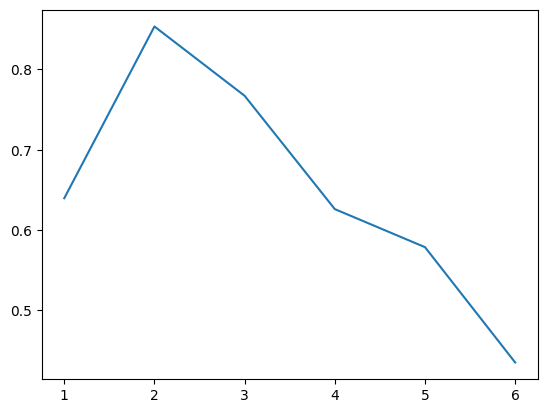

In [21]:

### Assume that LHS vertices are numbered 0, 1, ..., U-1
### Assume the RHS vertices are numbered 0, 1, ..., V-1

### Assume that weights w_{t, u, v} ~ U[0,1]

### Assume that the vertex disappears for K steps deterministically

U = 20
V = 4
T = 10

K = 1

X = list()
Y = list()

for K in [1, 2, 3, 4, 5, 6]:
    ratios = list()
    for _ in range(1):
        W = [[[random.uniform(0, 1) for j in range(V)] for i in range(U)] for t in range(T)]
        pvt = [[1. / V for v in range(V)] for t in range(T)]

        LHS = range(U)
        RHS = range(V)

        ### matched_pairs is assumed to be of the form t: (u, v)
        matched_pairs, total_weight = getMatching(LHS, RHS, W, pvt, T, K)
        Xopt, optimal = solveLP(LHS, RHS, W, pvt, T, K)
        ratios.append(total_weight / optimal)
    X.append(K)
    Y.append(mean(ratios))
    print(mean(ratios))

plt.plot(X, Y)